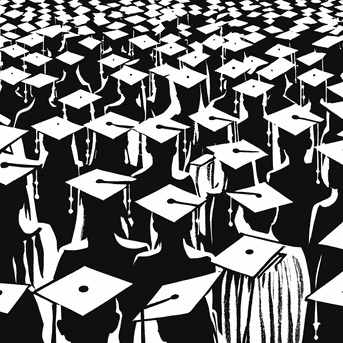

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import optuna
from sklearn.model_selection import StratifiedKFold, KFold
from tqdm import tqdm
from xgboost import XGBClassifier, XGBRegressor, plot_importance
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, r2_score
from scipy.stats import mode
from matplotlib.ticker import MaxNLocator
import plotly.express as px
print('\nImporting Libraries is a Success!')


Importing Libraries is a Success!


## 1. Loading in the Data

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s4e6/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e6/test.csv')
sub = pd.read_csv('/kaggle/input/playground-series-s4e6/sample_submission.csv')

print(f'Shape of the train: {train.shape}')
print(f'Shape of the test:  {test.shape}')
print(f'Shape of the sub:   {sub.shape}')

Shape of the train: (76518, 38)
Shape of the test:  (51012, 37)
Shape of the sub:   (51012, 2)


## 2. Getting Familiar with the Datasets

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76518 entries, 0 to 76517
Data columns (total 38 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   id                                              76518 non-null  int64  
 1   Marital status                                  76518 non-null  int64  
 2   Application mode                                76518 non-null  int64  
 3   Application order                               76518 non-null  int64  
 4   Course                                          76518 non-null  int64  
 5   Daytime/evening attendance                      76518 non-null  int64  
 6   Previous qualification                          76518 non-null  int64  
 7   Previous qualification (grade)                  76518 non-null  float64
 8   Nacionality                                     76518 non-null  int64  
 9   Mother's qualification                 

In [4]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,76518.0,38258.500000,22088.988286,0.00,19129.250000,38258.500000,57387.750000,76517.000
Marital status,76518.0,1.111934,0.441669,1.00,1.000000,1.000000,1.000000,6.000
Application mode,76518.0,16.054419,16.682337,1.00,1.000000,17.000000,39.000000,53.000
Application order,76518.0,1.644410,1.229645,0.00,1.000000,1.000000,2.000000,9.000
Course,76518.0,9001.286377,1803.438531,33.00,9119.000000,9254.000000,9670.000000,9991.000
Daytime/evening attendance,76518.0,0.915314,0.278416,0.00,1.000000,1.000000,1.000000,1.000
Previous qualification,76518.0,3.658760,8.623774,1.00,1.000000,1.000000,1.000000,43.000
Previous qualification (grade),76518.0,132.378766,10.995328,95.00,125.000000,133.100000,140.000000,190.000
Nacionality,76518.0,1.226600,3.392183,1.00,1.000000,1.000000,1.000000,109.000
Mother's qualification,76518.0,19.837633,15.399456,1.00,1.000000,19.000000,37.000000,44.000


## 3. Exploratory Data Analysis

### Target Distribution

In [5]:
category_count_train = train['Target'].value_counts().reset_index()
category_count_train.columns = ['Target', 'Count']

fig = px.pie(category_count_train, 
             values = 'Count', 
             names = 'Target', 
             title = 'Target Distribution', 
             labels = {'Target':'Category', 'Count':'Count'},
             hole = 0)

fig.update_traces(textposition = 'inside', textinfo = 'percent+label')
fig.update_layout(showlegend = True, title_x = 0.5)
fig.show()

### Feature Distribution

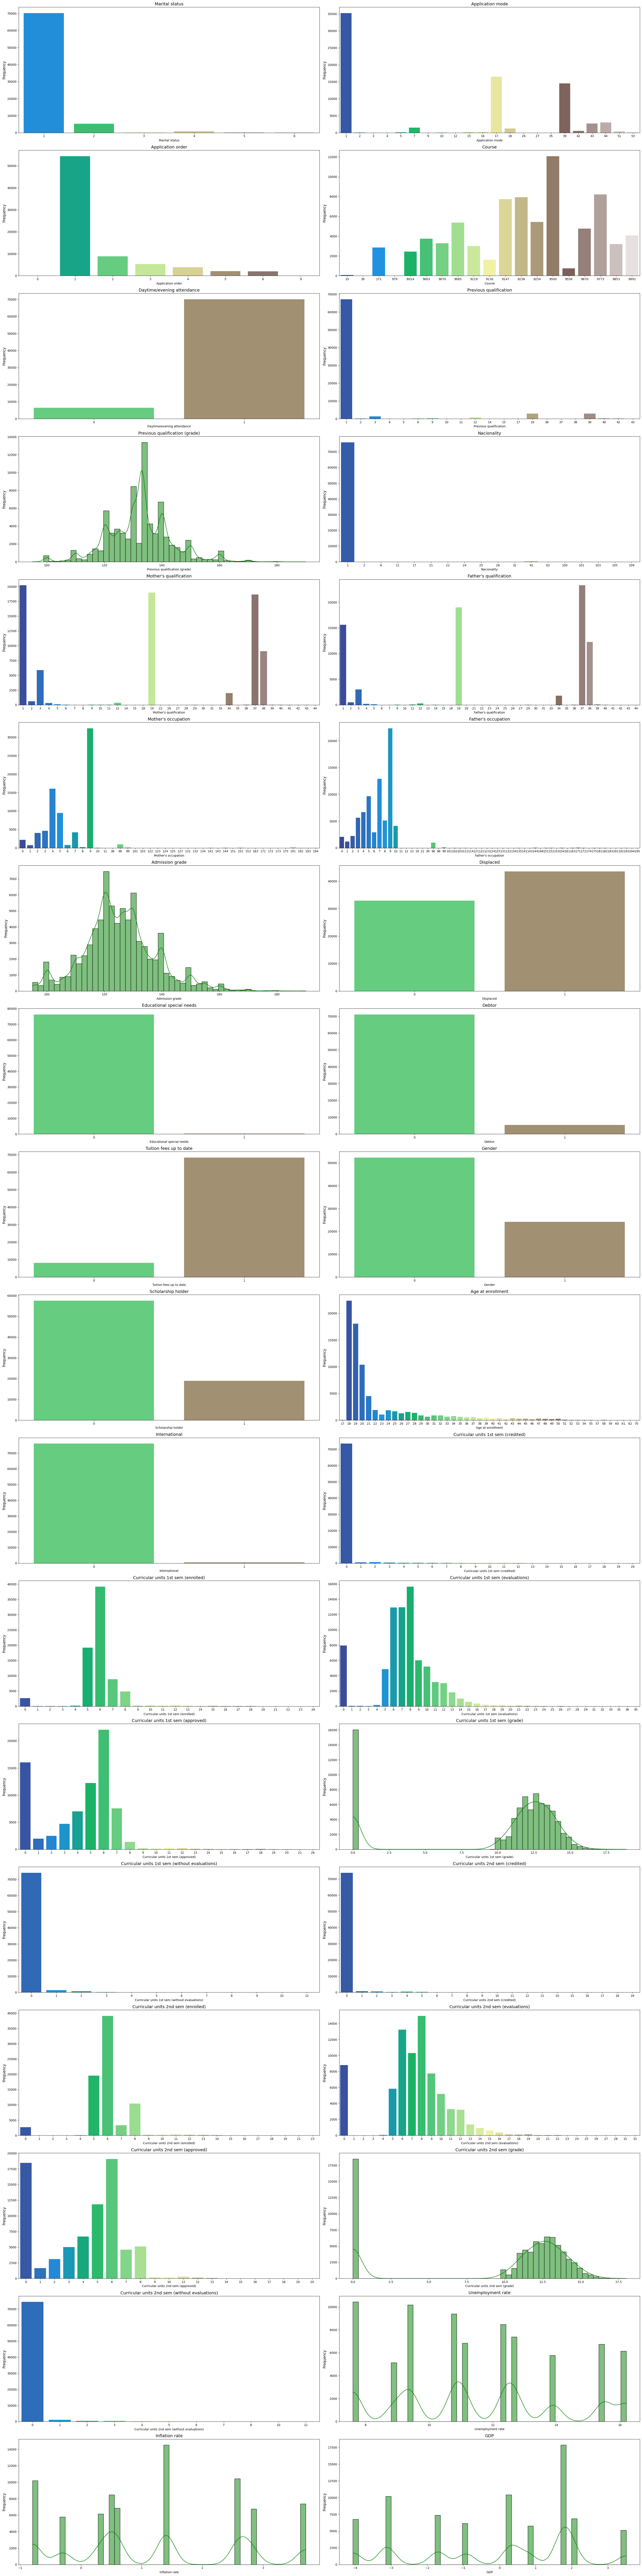

In [6]:
cat_cols = [cols for cols in train.select_dtypes(int).columns]

fig, axis = plt.subplots(18, 2, figsize = (30, 120))
plt.subplots_adjust(hspace = 0.6)

for cols, ax in zip(train.drop(columns = ['id', 'Target']).columns, axis.ravel()):
    if cols in cat_cols:
        sns.countplot(data = train, x = train[cols], ax = ax, 
#                       hue = train['Target'], 
                      palette = 'terrain')
    else:
        sns.histplot(data = train, x = train[cols], ax = ax, bins = 50, color = 'green', kde = True)
    ax.set_ylabel('Frequency', fontsize = 12)
    ax.set_title(cols, fontsize = 14)
#     ax.grid(True, linestyle = '--', alpha = 0.7)
    
plt.tight_layout()
plt.show()

### Feature Correlation Heatmap

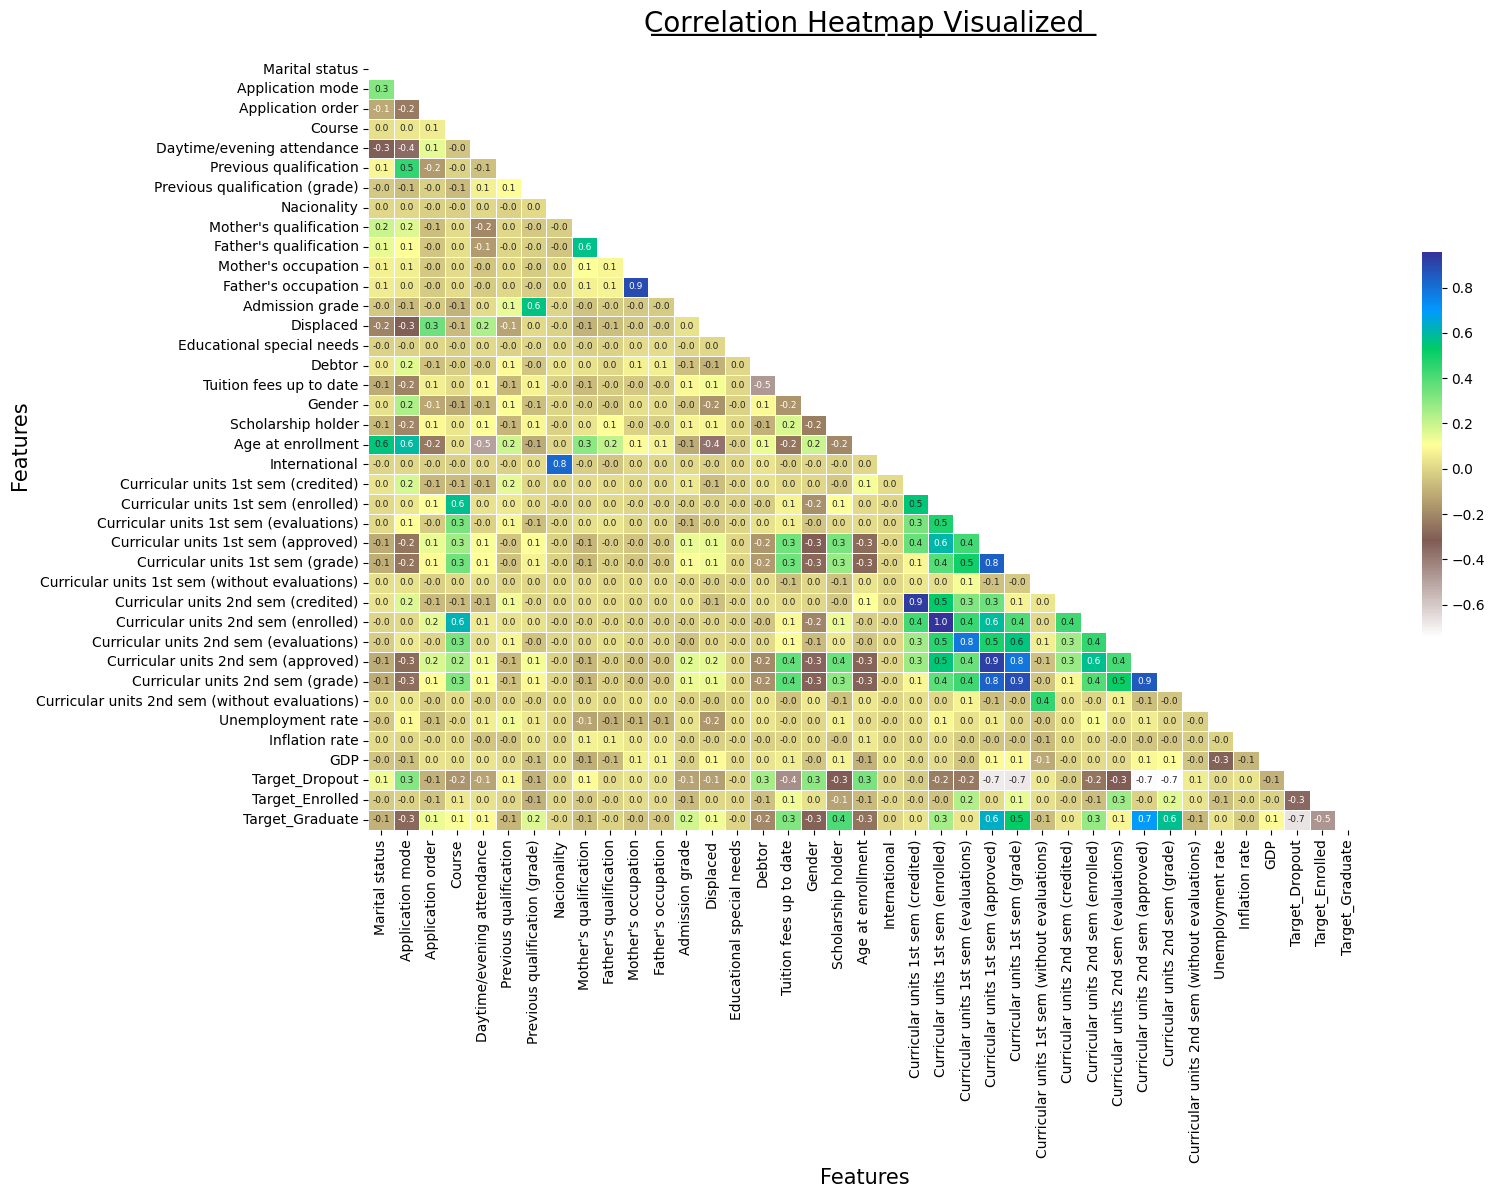

In [7]:
train_enc = pd.get_dummies(train.drop(columns = ['id']))
corr = train_enc.corr()
mask = np.triu(np.ones_like(corr, dtype = bool))
plt.figure(figsize = (16, 10))
sns.heatmap(data = corr, cmap = 'terrain_r', annot = True, fmt = '.1f', annot_kws = {'fontsize': 6.5}, 
            mask = mask, cbar_kws = {"shrink": .5}, linewidths = .5)
plt.title('C͟o͟r͟r͟e͟l͟a͟t͟i͟o͟n͟ ͟H͟e͟a͟t͟m͟a͟p͟ ͟V͟i͟s͟u͟a͟l͟i͟z͟e͟d͟', fontsize = 20, pad = 20)
plt.xlabel('Features', fontsize = 15)
plt.ylabel('Features', fontsize = 15)
plt.show()

## 3. Data Preprocessing and Pipeline Construction

In [8]:
class DataPipeline:
    def __init__(self, train, test):
        self.train = train
        self.test = test
        self.X = None
        self.y = None
        self.df = None
        self.scaled_df = None

    def concatenate_data(self):
        X = self.train.loc[:, 'id': 'GDP']
        self.df = pd.concat([X, self.test], axis = 0)
        y = self.train[['Target']]
        le = LabelEncoder()
        y['Target'] = le.fit_transform(y['Target'])
        self.X, self.y = X, y
        return self.X, self.y, self.df
    
    # Adding some statistical features and creating some new feautures
    # Using MinMaxScaler after that, for data uniformity
    # Dropping the 'id' column

    def preprocess_data(self):
        df = self.df.copy()
        df['total'] = df.sum(axis = 1)
        df['mean'] = df.mean(axis = 1)
        df['median'] = df.median(axis = 1)
        df['std'] = df.std(axis = 1)
        df['min'] = df.min(axis = 1)
        df['max'] = df.max(axis = 1)
        df['ptp'] = df.values.ptp(axis = 1)
        df['q25'] = df.quantile(0.25, axis = 1)
        df['q75'] = df.quantile(0.75, axis = 1)
        df['credited_avg'] = (df['Curricular units 1st sem (credited)'] + df['Curricular units 2nd sem (credited)']) / 2
        df['enrolled_avg'] = (df['Curricular units 1st sem (enrolled)'] + df['Curricular units 2nd sem (enrolled)']) / 2
        df['evaluations_avg'] = (df['Curricular units 1st sem (evaluations)'] + df['Curricular units 2nd sem (evaluations)']) / 2
        df['approved_avg'] = (df['Curricular units 1st sem (approved)'] + df['Curricular units 2nd sem (approved)']) / 2
        df['grade_avg'] = (df['Curricular units 1st sem (grade)'] + df['Curricular units 2nd sem (grade)']) / 2
        df['wo_evaluations_avg'] = (df['Curricular units 1st sem (without evaluations)'] + 
                                    df['Curricular units 2nd sem (without evaluations)']) / 2
        df['Age_at_enrollment_cat'] = pd.cut(df['Age at enrollment'], 
                                             bins = [18, 24, 30, 35, 40], 
                                             labels = [1, 2, 3, 4])
        df['Parents_qualification_avg'] = (df["Mother's qualification"] + df["Father's qualification"]) / 2
        df['Parents_occupation_avg'] = (df["Mother's occupation"] + df["Father's occupation"]) / 2
        df['Unemployment_Inflation_ratio'] = (df['Unemployment rate'] + 1) / (df['Inflation rate'] + 1)

        df_cols = df.columns
        scaler = MinMaxScaler()
        df = scaler.fit_transform(df)
        df = pd.DataFrame(df, columns = df_cols)
        
        if 'id' in df.columns:
            df.drop(columns = ['id'], inplace = True)
        
        self.scaled_df = df
        return self.scaled_df
    
    # Splitting the Data for Modelling

    def split_data(self):
        len_X = len(self.X)
        len_test = len(self.test)
        X_preprocessed = self.scaled_df.iloc[:len_X]
        test_preprocessed = self.scaled_df.iloc[len_X: len_X + len_test]
        return X_preprocessed, test_preprocessed

    def run_pipeline(self):
        self.concatenate_data()
        self.preprocess_data()
        X_preprocessed, test_preprocessed = self.split_data()
        return self.X, self.y, X_preprocessed, test_preprocessed

# Running the Pipeline    
pipeline = DataPipeline(train, test)
X, y, X_preprocessed, test_preprocessed = pipeline.run_pipeline()
print(len(X), len(y), len(X_preprocessed), len(test_preprocessed))

76518 76518 76518 51012


## 4. Modelling for Classification

After conducting hyperparameter tuning with Optuna to maximize accuracy, we obtained the following parameters:

In [9]:
best_xgb_params =  {'n_estimators': 1168, 
                   'learning_rate': 0.021899695434225392, 
                   'max_depth': 9, 
                   'min_child_weight': 7, 
                   'subsample': 0.8833415189829511, 
                   'colsample_bytree': 0.47870555779903173, 
                   'reg_alpha': 0.003962141750526502, 
                   'reg_lambda': 0.0005483724027167153, 
                   'gamma': 0.9706261279770567, 
                   'scale_pos_weight': 29.598024870063032}

best_catb_params = {'iterations': 1060, 
                    'learning_rate': 0.12870938526369563, 
                    'depth': 5, 
                    'min_data_in_leaf': 2, 
                    'colsample_bylevel': 0.5571138654353053, 
                    'l2_leaf_reg': 3.917650301267089, 
                    'random_strength': 4.0271592863936245, 
                    'bagging_temperature': 0.20975982889738484}

In [10]:
kf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
test_preds_xgb = []
accuracy_scores_xgb = []
for train_index, test_index in tqdm(kf.split(X_preprocessed, y), total = kf.get_n_splits(), desc = 'Training models'):
    X_train, X_test = X_preprocessed.iloc[train_index], X_preprocessed.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
    model_xgb = XGBClassifier(**best_xgb_params, verbosity = 0)
    model_xgb.fit(X_train, y_train, eval_set = [(X_test, y_test)], verbose = False)
    
    y_preds_xgb = model_xgb.predict(X_test)
    
    accuracy_xgb = accuracy_score(y_test, y_preds_xgb)
        
    accuracy_scores_xgb.append(accuracy_xgb)
    
    test_pred_xgb = model_xgb.predict(test_preprocessed)
    test_preds_xgb.append(test_pred_xgb)
    
avg_acc_xgb = np.mean(accuracy_scores_xgb)
print(f'\n\nThe Accuracy achieved by the xgboost model for 10-Folds is: {round(avg_acc_xgb, 6)}')

Training models: 100%|██████████| 10/10 [07:53<00:00, 47.34s/it]



The Accuracy achieved by the xgboost model for 10-Folds is: 0.833281


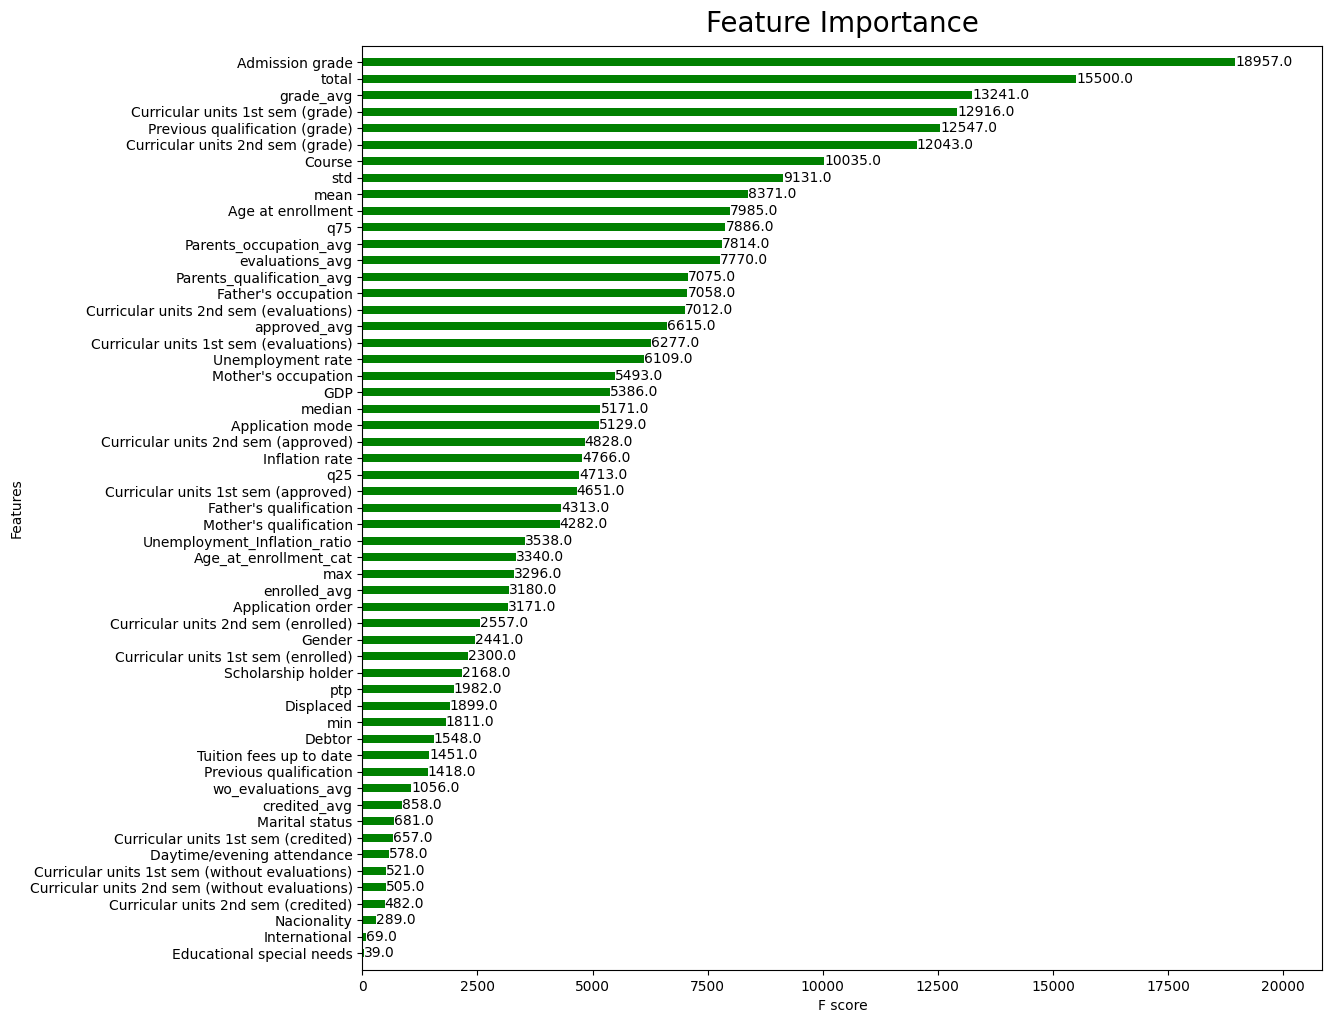

In [11]:
fig, ax = plt.subplots(figsize = (16, 12))
plot_importance(booster = model_xgb, ax = ax, grid = False, color = 'green', height = 0.5)
plt.subplots_adjust(left = 0.3)
plt.title('Feature Importance', pad = 10, fontsize  = 20)
plt.show()

In [12]:
test_preds_catb = []
accuracy_scores_catb = []
kf_catb = KFold(n_splits = 5, shuffle = True, random_state = 42)
for train_index, test_index in tqdm(kf_catb.split(X_preprocessed, y), total = kf_catb.get_n_splits(), 
                                    desc = 'Training models'):
    X_train, X_test = X_preprocessed.iloc[train_index], X_preprocessed.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
    model_catb = CatBoostClassifier(**best_catb_params, logging_level = 'Silent', loss_function = 'MultiClass')
    model_catb.fit(X_train, y_train, eval_set = (X_test, y_test))
    
    y_preds_catb = model_catb.predict(X_test)
    
    accuracy_catb = accuracy_score(y_test, y_preds_catb)
        
    accuracy_scores_catb.append(accuracy_catb)
    
    test_pred_catb = model_catb.predict(test_preprocessed)
    test_preds_catb.append(test_pred_catb)
    
avg_acc_catb = np.mean(accuracy_scores_catb)
print(f'\n\nThe Accuracy achieved by the catboost model for 10-Folds is: {round(avg_acc_catb, 6)}')

Training models: 100%|██████████| 5/5 [03:15<00:00, 39.19s/it]



The Accuracy achieved by the catboost model for 10-Folds is: 0.831857


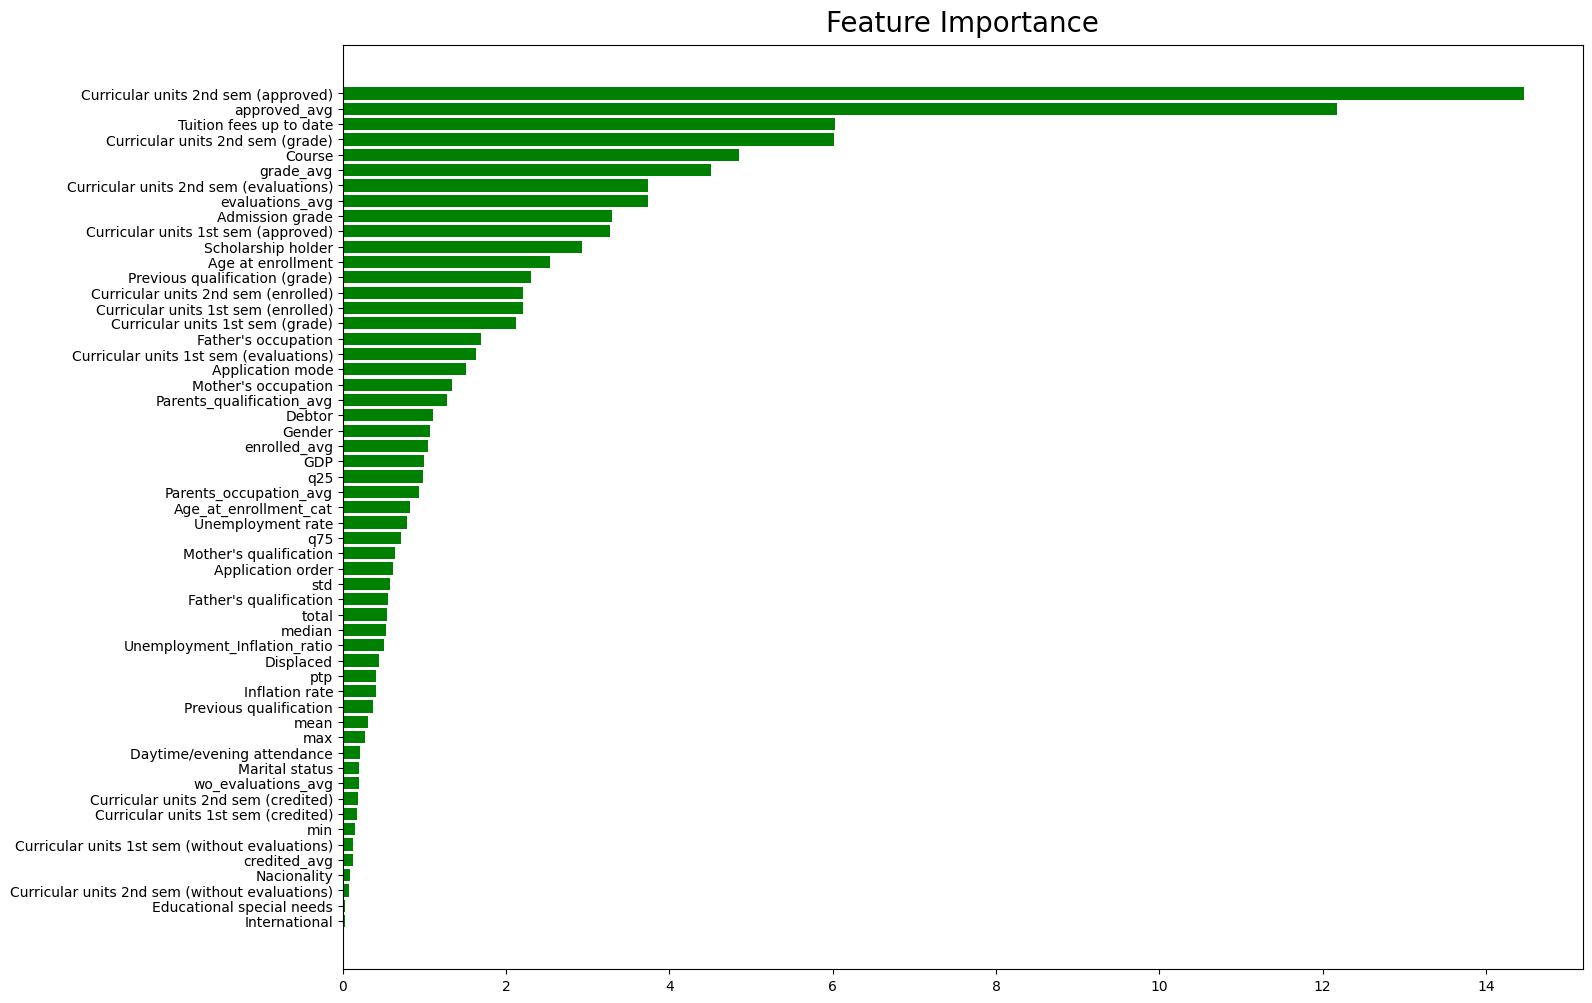

In [13]:
sorted_indices = np.argsort(model_catb.feature_importances_)
sorted_feature_importance = model_catb.feature_importances_[sorted_indices]
sorted_feature_names = X_train.columns[sorted_indices]
plt.figure(figsize = (16, 12))
plt.title('Feature Importance', fontsize  = 20, pad = 10)
plt.barh(sorted_feature_names, sorted_feature_importance, color = 'green')
plt.show()

## 5. Submission

In [14]:
array_list = []
for array in test_preds_catb:
    array_1d_reshape = array.reshape(-1)
    array_1d_index = array[:, 0]
    array_list.append(array_1d_index)

In [15]:
result_list = test_preds_xgb.copy()
result_list.extend(array_list)

In [16]:
result_list_mode = mode(result_list, axis = 0)

In [17]:
def submission(mode_array):
    sub['Target'] = mode_array[0]
    sub['Target'] = sub['Target'].map({0: 'Dropout', 1: 'Enrolled', 2: 'Graduate'})
    sub.to_csv('submission.csv', index = False)
    
submission(result_list_mode)